In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from pandas import set_option

np.set_printoptions(precision=2)
set_option('display.precision', 4)

from functools import reduce

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

## Concatenated df analysis

In [106]:
df = pd.read_csv('../data/Stat-TM.csv', sep=';')
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

datetime unit  number
0 2019-07-31 14:03:39.500   P2       1
1 2019-07-31 14:04:01.480   P2       1
2 2019-07-31 14:10:25.897   P2       1
3 2019-07-31 14:12:48.353   P2       1
4 2019-07-31 14:15:23.587   P2       1

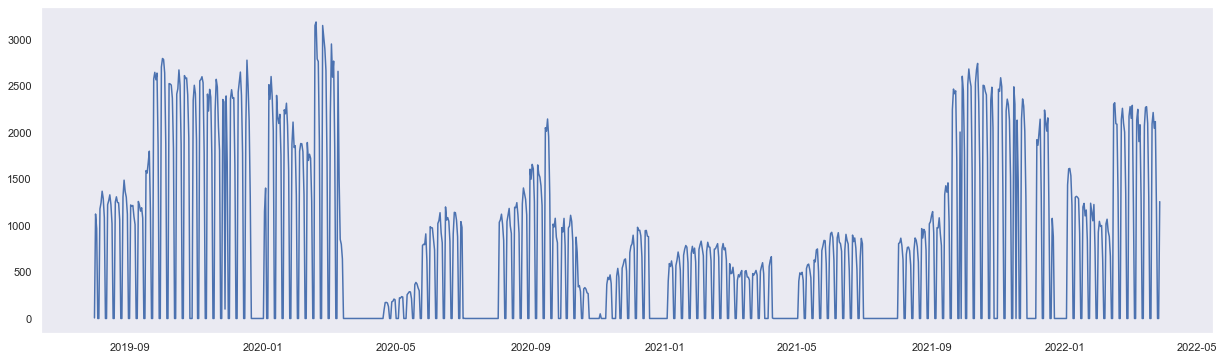

In [107]:
df_day = df.groupby(pd.Grouper(key='datetime', freq='1D')).sum()

plt.figure(figsize=(21, 6))
plt.plot(df_day['number'])
plt.grid()
plt.show()

## Time binning aggregation

In [108]:
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df = df[['datetime', 'date', 'time', 'unit', 'number']]
# df['time'] = pd.to_datetime(df['time'])
df['date'] = pd.to_datetime(df['date'])
df

datetime       date             time unit  number
0      2019-07-31 14:03:39.500 2019-07-31  14:03:39.500000   P2       1
1      2019-07-31 14:04:01.480 2019-07-31  14:04:01.480000   P2       1
2      2019-07-31 14:10:25.897 2019-07-31  14:10:25.897000   P2       1
3      2019-07-31 14:12:48.353 2019-07-31  14:12:48.353000   P2       1
4      2019-07-31 14:15:23.587 2019-07-31  14:15:23.587000   P2       1
...                        ...        ...              ...  ...     ...
737641 2022-03-28 11:57:33.673 2022-03-28  11:57:33.673000   P3       1
737642 2022-03-28 11:57:35.113 2022-03-28  11:57:35.113000   P4       1
737643 2022-03-28 11:57:39.540 2022-03-28  11:57:39.540000   P3       1
737644 2022-03-28 11:57:40.577 2022-03-28  11:57:40.577000   P2       1
737645 2022-03-28 11:57:45.967 2022-03-28  11:57:45.967000   P3       1

[737646 rows x 5 columns]

In [109]:
df_inc = df.groupby(pd.Grouper(key='datetime', axis=0, freq='1D')).sum()
# df_inc = pd.concat([df_inc.loc['2019-09-23':'2019-12-12'], 
#            df_inc.loc['2021-09-20':'2021-12-19'],
#            df_inc.loc['2022-02-14':'2022-5-15']], axis=0).reset_index()
df_inc = df_inc[df_inc['number'] == 0].reset_index()
ex_dates = pd.to_datetime(list(df_inc['datetime'].astype(str).values))

In [110]:
df_in = df.groupby([pd.Grouper(key='datetime',
                               freq='15min', 
                               origin='2019-07-31 14:00', 
                               closed='left', label='left')]).sum().reset_index()
df_in['time'] = df_in['datetime'].dt.time
df_in = df_in[['datetime', 'time', 'number']]
df_in = df_in[~df_in['datetime'].dt.normalize().isin(ex_dates)]

## Group by time intervals

## Semesters

2019 1:
- Výuka 23.9.2019 - 19.12.2019
- zkouškové 6.1.2020 - 15.2.2020

2019 2: 
- 17.2.2020 - 16.5.2020
- 18.5.2020 - 21.6.2020

2020 1: 
- 21.9.2020 - 18.12.2020
- 4.1.2021 - 14.2.2021

2020 2: covid
- 15.2.2021 - 16.5.2021
- 17.5.2021 - 27.6.2021

2021 1: 
- 20.9.2021 - 19.12.2021
- 3.1.2022 - 13.2.2022

2021 2:
- 14.2.2022 - 15.5.2022
- 16.5.2022 - 26.6.2022

In [111]:
df_filtered = df_in.copy().set_index('datetime')
# Semesters
df_study = pd.concat([df_filtered.loc['2019-09-23':'2019-12-12'], 
           df_filtered.loc['2021-09-20':'2021-12-19'],
           df_filtered.loc['2022-02-14':'2022-5-15']], axis=0).reset_index()

df_study_int = df_study.groupby('time').mean()
df_study_int = df_study_int.sort_values(by='time')
df_study_int = df_study_int[(df_study_int != 0).all(1)]
df_study_int = df_study_int.reset_index()
df_study_int.head(5)

time  number
0  05:45:00  0.1241
1  06:00:00  0.2414
2  06:15:00  0.1655
3  06:30:00  0.3310
4  06:45:00  0.2621

In [112]:
intervals = df_study_int['time']

df_blank = pd.DataFrame(intervals)
df_blank['number'] = pd.Series([0 for x in range(len(intervals.index))]) 
df_blank.head()

time  number
0  05:45:00       0
1  06:00:00       0
2  06:15:00       0
3  06:30:00       0
4  06:45:00       0

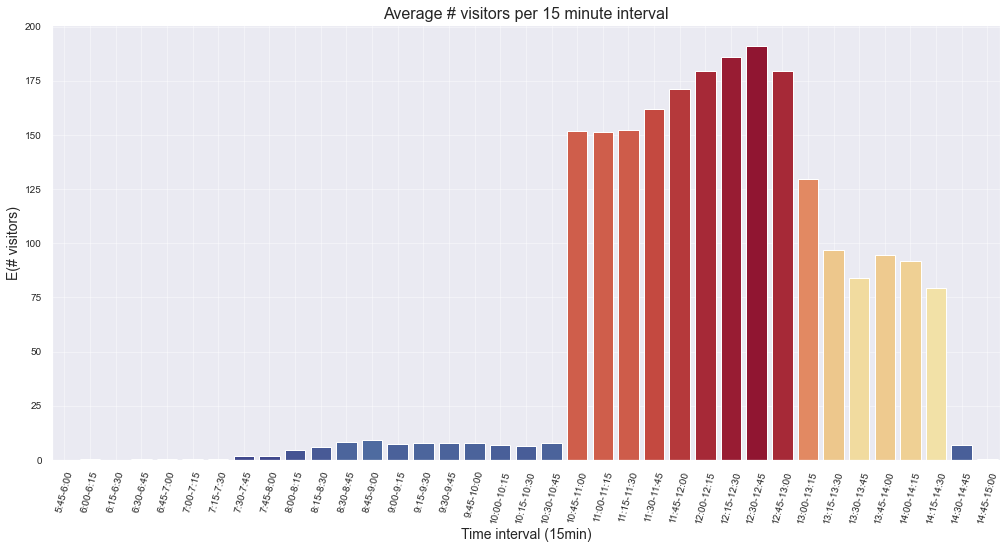

In [113]:
plt.figure(figsize=(17, 8))

norm = TwoSlopeNorm(vmin=df_study_int.number.min(), vcenter=df_study_int.number.mean(), vmax=df_study_int.number.max())
pal = [plt.cm.RdYlBu_r(norm(c)) for c in df_study_int['number']]

ax = sns.barplot(x='time', y='number', data=df_study_int, palette=pal)

# ax.axhline(100, color='red', linestyle='dashed', alpha=0.8)
# for i in ax.containers:
#     ax.bar_label(i,)

plt.title('Average # visitors per 15 minute interval', fontdict={'fontsize': 16})
plt.ylabel('E(# visitors)', fontdict={'fontsize': 14})
plt.xlabel('Time interval (15min)', fontdict={'fontsize': 14})

ticks = np.concatenate([['5:45-6:00'], np.array([[f'{x}:00-{x}:15', f'{x}:15-{x}:30', f'{x}:30-{x}:45', f'{x}:45-{x+1}:00'] for x in [6, 7, 8, 9, 10, 11, 12, 13, 14]]).reshape(-1)], axis=0)
plt.xticks(range(len(df_study_int.index)), ticks, rotation=75)
# plt.xticks(range(len(df_study_int.index)), ticks[:-1], rotation=75)
plt.tick_params(labelsize=10)
plt.grid(alpha=0.4)
plt.show()

### Percent distribution

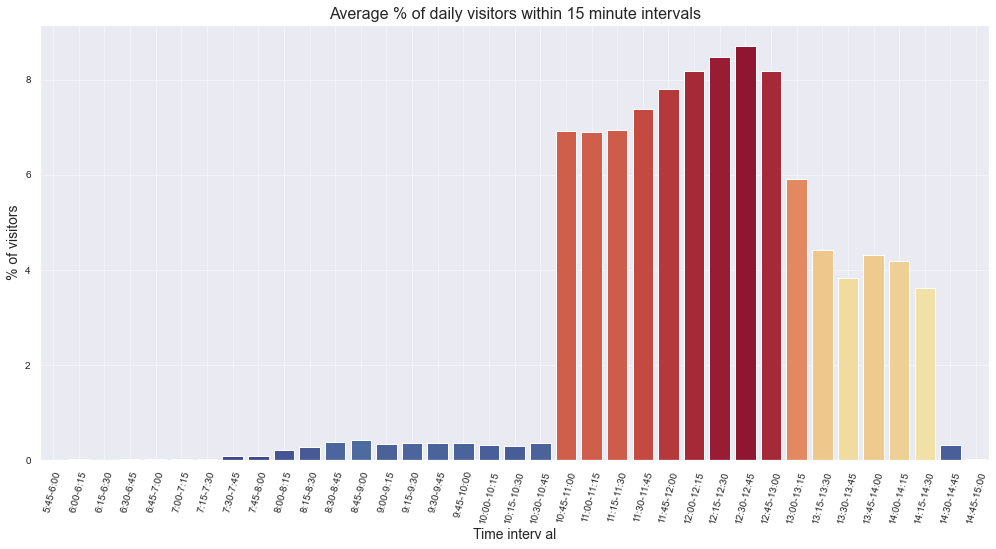

In [70]:
total_avg = sum(df_study_int['number'])
df_study_int_pc = df_study_int.copy()
df_study_int_pc['number'] = df_study_int_pc['number'] / total_avg * 100
norm = TwoSlopeNorm(vmin=df_study_int_pc.number.min(), vcenter=df_study_int_pc.number.mean(), vmax=df_study_int_pc.number.max())
pal = [plt.cm.RdYlBu_r(norm(c)) for c in df_study_int_pc['number']]

plt.figure(figsize=(17, 8))

ax = sns.barplot(x='time', y='number', data=df_study_int_pc, palette=pal)

# ax.axhline(100, color='red', linestyle='dashed', alpha=0.8)
# ax.bar_label(ax.containers[0], rotation=90, padding=2)

plt.title('Average % of daily visitors within 15 minute intervals', fontdict={'fontsize': 16})
plt.ylabel('% of visitors', fontdict={'fontsize': 14})
plt.xlabel('Time interv al', fontdict={'fontsize': 14})

ticks = np.concatenate([['5:45-6:00'], np.array([[f'{x}:00-{x}:15', f'{x}:15-{x}:30', f'{x}:30-{x}:45', f'{x}:45-{x+1}:00'] for x in [6, 7, 8, 9, 10, 11, 12, 13, 14]]).reshape(-1)], axis=0)
plt.xticks(range(len(df_study_int_pc.index)), ticks, rotation=75)
# plt.xticks(range(len(df_study_int.index)), ticks[:-1], rotation=75)
plt.tick_params(labelsize=10)
plt.grid(alpha=0.4)
plt.show()

## TODO
### same but for a specific unit, exam periods, covid periods, more attractive visualization, consultation with stats teacher nb?

### By unit

In [114]:
def dist_by_unit(data, df_blank, ymax=None, unit='P1', plot=True, name='number'):
    df_unit = data[data['unit'] == unit]
    # df_unit = df_unit.set_index('datetime')
    # df_unit = pd.concat([df_unit.loc['2019-09-23':'2019-12-12'], 
    #            df_unit.loc['2022-02-14':'2022-5-15'],
    #            df_unit.loc['2022-02-14':'2022-5-15']], axis=0).reset_index()


    df_unit_int = df_unit.groupby('time').mean()
    df_unit_int = df_unit_int.sort_values(by='time')
    df_unit_int = df_unit_int[(df_unit_int != 0).all(1)]
    df_unit_int = df_unit_int.reset_index()
    
    df_unit_int = df_blank.merge(df_unit_int, on=['time'], how='left').\
        drop(['number_x'], axis=1).\
            rename({'number_y': name}, axis=1).fillna(0)
            
    if plot:
        plt.figure(figsize=(17, 8))

        df_unit_int.plot.bar(x='time', y=name, figsize=(17, 8), label='Average # of visitors', )
        plt.ylabel('E(# visitors)')
        plt.xlabel('Time interval (15min)')
        plt.title(f'Average # visitors per 15 minute interval (unit {unit})')

        if ymax is not None:
            plt.ylim([0, ymax])

        plt.show()
    else:
        return df_unit_int

In [115]:
df_unit = df.groupby([pd.Grouper(key  ='datetime',
                               freq   ='15min', 
                               origin ='2019-07-31 14:00', 
                               closed ='left', label='left'),
                      'unit']).sum().reset_index()
df_unit['time'] = df_unit['datetime'].dt.time
df_unit = df_unit[['datetime', 'time', 'unit', 'number']]

# Filtering
df_unit = df_unit[~df_unit['datetime'].dt.normalize().isin(ex_dates)]

df_unit = df_unit.set_index('datetime')
df_unit = pd.concat([df_unit.loc['2019-09-23':'2019-12-12'], 
                     df_unit.loc['2021-09-20':'2021-12-19'],
                     df_unit.loc['2022-02-14':'2022-5-15']], axis=0).reset_index()

df_unit

datetime      time unit  number
0     2019-09-23 07:00:00  07:00:00   P3       1
1     2019-09-23 07:30:00  07:30:00   P1       2
2     2019-09-23 07:45:00  07:45:00   P1       6
3     2019-09-23 08:00:00  08:00:00   P1       9
4     2019-09-23 08:15:00  08:15:00   P1      15
...                   ...       ...  ...     ...
11459 2022-03-28 12:15:00  12:15:00   P3      65
11460 2022-03-28 12:15:00  12:15:00   P4      70
11461 2022-03-28 12:30:00  12:30:00   P2      14
11462 2022-03-28 12:30:00  12:30:00   P3      19
11463 2022-03-28 12:30:00  12:30:00   P4      30

[11464 rows x 4 columns]

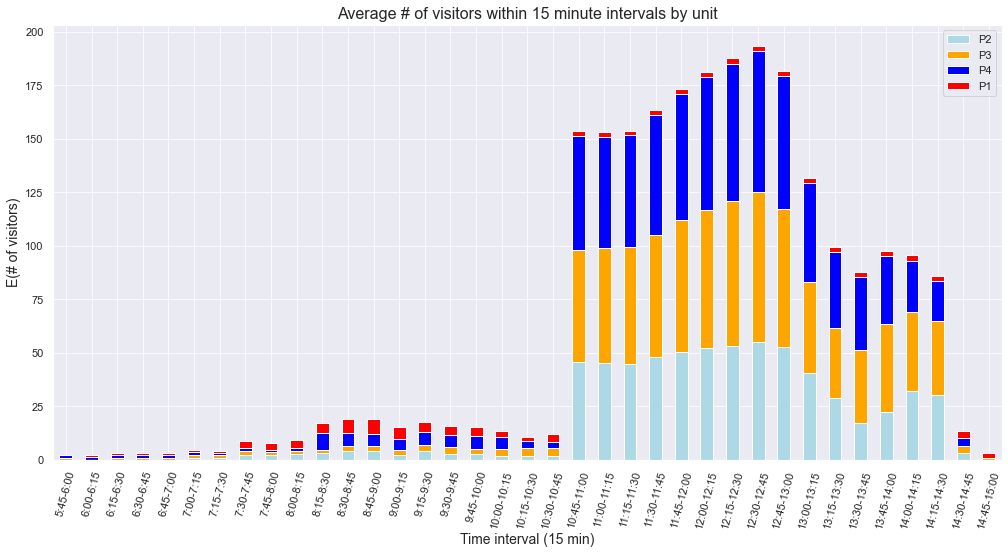

In [73]:
df_list = []
for u in ['P2', 'P3', 'P4', 'P1']:
    df_u = dist_by_unit(df_unit, df_blank, ymax=df_study_int.number.max(), unit=u, plot=False, name=u)
    df_list.append(df_u)

df_final = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
                                            how='inner'), df_list)

sns.set(rc={"figure.figsize":(17, 8)})
ax = df_final.set_index('time').plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'blue', 'red'])

plt.title('Average # of visitors within 15 minute intervals by unit', fontdict={'fontsize': 16})
plt.ylabel('E(# of visitors)', fontdict={'fontsize': 14})
plt.xlabel('Time interval (15 min)', fontdict={'fontsize': 14})

ticks = np.concatenate([['5:45-6:00'], np.array([[f'{x}:00-{x}:15', f'{x}:15-{x}:30', f'{x}:30-{x}:45', f'{x}:45-{x+1}:00'] for x in [6, 7, 8, 9, 10, 11, 12, 13, 14]]).reshape(-1)], axis=0)
plt.xticks(range(len(df_study_int.index)), ticks, rotation=75)
plt.grid(alpha=0.8)
plt.show()

### Distribution of load in % within 15 min intervals

In [116]:
totals = [i+j+k+q for i,j,k,q in zip(df_final['P2'], 
                                     df_final['P3'], 
                                     df_final['P4'], 
                                     df_final['P1'])]

p2 = [i / j * 100 for i,j in zip(df_final['P2'], totals)]
p3 = [i / j * 100 for i,j in zip(df_final['P3'], totals)]
p4 = [i / j * 100 for i,j in zip(df_final['P4'], totals)]
p1 = [i / j * 100 for i,j in zip(df_final['P1'], totals)]

df_final_pc = pd.DataFrame({'P2': p2,
                            'P3': p3,
                            'P4': p4,
                            'P1': p1})

df_final_pc.head(5)

P2       P3       P4       P1
0  0.0  45.1613  54.8387   0.0000
1  0.0   0.0000  49.7925  50.2075
2  0.0  30.8300  35.9684  33.2016
3  0.0  31.2500  31.2500  37.5000
4  0.0  31.2500  31.2500  37.5000

<Figure size 1224x576 with 0 Axes>

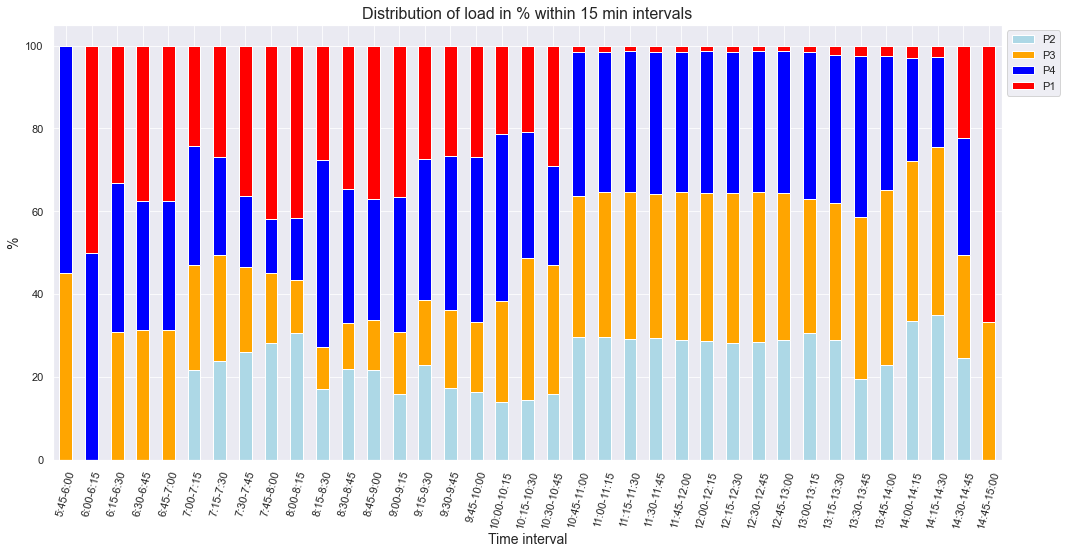

In [117]:
plt.figure(figsize=(17, 8))

ax = df_final_pc.plot(kind='bar', stacked='True', color=['lightblue', 'orange', 'blue', 'red'])

plt.title('Distribution of load in % within 15 min intervals', fontdict={'fontsize': 16})
plt.ylabel('%', fontdict={'fontsize': 14})
plt.xlabel('Time interval', fontdict={'fontsize': 14})


# ax.margins(y=0.1) # make room for the labels
# for bars in ax.containers:
#     ax.bar_label(bars, fmt='%.1f', rotation=90, label_type='edge', color='black', size=9, padding=10)

ticks = np.concatenate([['5:45-6:00'], np.array([[f'{x}:00-{x}:15', f'{x}:15-{x}:30', f'{x}:30-{x}:45', f'{x}:45-{x+1}:00'] for x in [6, 7, 8, 9, 10, 11, 12, 13, 14]]).reshape(-1)], axis=0)
plt.xticks(range(len(df_study_int.index)), ticks, rotation=75)
plt.grid(alpha=0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()

### What if include average lunch duration and approximate the number of simultaneous visitors?

In [118]:
duration = 20

df_tmp = df.copy()

leave_time = df_tmp['datetime'] + pd.Timedelta(minutes=duration)
df_tmp['ldatetime'] = leave_time
df_tmp['date'] = df_tmp['datetime'].dt.date
df_tmp = df_tmp[['date', 'datetime', 'ldatetime', 'unit', 'number']]
df_tmp

date                datetime               ldatetime unit  \
0       2019-07-31 2019-07-31 14:03:39.500 2019-07-31 14:23:39.500   P2   
1       2019-07-31 2019-07-31 14:04:01.480 2019-07-31 14:24:01.480   P2   
2       2019-07-31 2019-07-31 14:10:25.897 2019-07-31 14:30:25.897   P2   
3       2019-07-31 2019-07-31 14:12:48.353 2019-07-31 14:32:48.353   P2   
4       2019-07-31 2019-07-31 14:15:23.587 2019-07-31 14:35:23.587   P2   
...            ...                     ...                     ...  ...   
737641  2022-03-28 2022-03-28 11:57:33.673 2022-03-28 12:17:33.673   P3   
737642  2022-03-28 2022-03-28 11:57:35.113 2022-03-28 12:17:35.113   P4   
737643  2022-03-28 2022-03-28 11:57:39.540 2022-03-28 12:17:39.540   P3   
737644  2022-03-28 2022-03-28 11:57:40.577 2022-03-28 12:17:40.577   P2   
737645  2022-03-28 2022-03-28 11:57:45.967 2022-03-28 12:17:45.967   P3   

        number  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
737641       1  
737642       1  
737643       1  
737644       1  
737645       1  

[737646 rows x 5 columns]

In [119]:
int_len = 5

df_day_int = df_tmp.groupby(['date',
                        pd.Grouper(key='datetime',
                               freq=f'{int_len}min', 
                               origin='2019-07-31 14:00', 
                               closed='left', label='left')]).sum().reset_index()
df_day_int['time'] = df_day_int['datetime'].dt.time
df_day_int = df_day_int[['datetime', 'date', 'time', 'number']]
df_day_int = df_day_int[~df_day_int['datetime'].dt.normalize().isin(ex_dates)]
df_day_int

datetime        date      time  number
0     2019-07-31 14:00:00  2019-07-31  14:00:00       2
1     2019-07-31 14:10:00  2019-07-31  14:10:00       2
2     2019-07-31 14:15:00  2019-07-31  14:15:00       2
3     2019-08-01 07:50:00  2019-08-01  07:50:00       1
4     2019-08-01 08:05:00  2019-08-01  08:05:00       2
...                   ...         ...       ...     ...
35036 2022-03-28 12:10:00  2022-03-28  12:10:00      67
35037 2022-03-28 12:15:00  2022-03-28  12:15:00      56
35038 2022-03-28 12:20:00  2022-03-28  12:20:00      65
35039 2022-03-28 12:25:00  2022-03-28  12:25:00      74
35040 2022-03-28 12:30:00  2022-03-28  12:30:00      63

[35041 rows x 4 columns]

In [120]:
df_day_int_f = df_day_int.copy().set_index('datetime')
# Exams
# df_study = pd.concat([df_filtered.loc['2020-06-01':'2020-02-15'], 
#            df_filtered.loc['2022-01-03':'2022-02-13'],
#            df_filtered.loc['2022-05-16':'2022-6-26']], axis=0).reset_index()
# Semesters
df_day_int_f = pd.concat([df_day_int_f.loc['2019-09-23':'2019-12-12'], 
           df_day_int_f.loc['2021-09-20':'2021-12-19'],
           df_day_int_f.loc['2022-02-14':'2022-5-15']], axis=0).reset_index()

print(f'Unique days: {len(set(df_day_int_f["date"]))}')
df_day_int_f

Unique days: 145


datetime        date      time  number
0     2019-09-23 07:10:00  2019-09-23  07:10:00       1
1     2019-09-23 07:40:00  2019-09-23  07:40:00       2
2     2019-09-23 07:45:00  2019-09-23  07:45:00       1
3     2019-09-23 07:50:00  2019-09-23  07:50:00       2
4     2019-09-23 07:55:00  2019-09-23  07:55:00       3
...                   ...         ...       ...     ...
10984 2022-03-28 12:10:00  2022-03-28  12:10:00      67
10985 2022-03-28 12:15:00  2022-03-28  12:15:00      56
10986 2022-03-28 12:20:00  2022-03-28  12:20:00      65
10987 2022-03-28 12:25:00  2022-03-28  12:25:00      74
10988 2022-03-28 12:30:00  2022-03-28  12:30:00      63

[10989 rows x 4 columns]

In [121]:
offset = duration // int_len
print(offset)
result = [group[1] for group in df_day_int_f.groupby('date')]
cumsum_res = [pd.Series(r['number'][offset:].values - r['number'][:-offset].values).cumsum() for r in result]

border = 255 #262
percentage = round(len([x for x in cumsum_res if (x > border).any()])/len(cumsum_res) * 100, 2)
print(f'Percentage of study days, when number of simultaneous visitors exceedes {border}: {percentage}%')

4
Percentage of study days, when number of simultaneous visitors exceedes 255: 76.55%


#### Mean number of visitors and average dinner duration

approx. 25 mins. But we need to decrease this value, because not always all the seats are busy... 20 mins seems relevant

In [136]:
dinner_duration = 225
capacity = 255
dinners_avg = 2300

print(f'{dinner_duration / (dinners_avg / capacity)}')

24.945652173913043


#### Approximation of the number of simultaneous visitors during dinner time

1. Filter dining time + 20 mins before and after
2. Compute the number of leavers
3. Compute cumsum of difference between new and leaving visitors -> number of simultaneous visitors throughout the dinner time
4. Possible statistics to compute: # TODO
   - percentage of temporal bins with exceeded capacity [x]
   - maximum number of simultaneous visitors [ ]
5. Also possible: # TODO
   - plot the percentage f temporal bins with exceeded capacity as a time series
   - plot maximum values?
   - determine the most problematic part of semester
   - determine the most problematic days of week???

In [123]:
def dinner_sim_binning(df: pd.DataFrame):
    dinner = df.set_index('datetime').between_time('10:25', '14:50').reset_index()

    date = str(dinner['date'].iloc[0])
    tmp = pd.DataFrame({'datetime': pd.Series(pd.date_range(start=f'{date} 10:25', end=f'{date} 14:50', freq='5min'))}).set_index('datetime')
    dinner = tmp.join(dinner.set_index('datetime'), on='datetime', how='left').reset_index()

    dinner['date'] = dinner['datetime'].dt.date
    dinner['time'] = dinner['datetime'].dt.time
    dinner.fillna(value=0, inplace=True)
    dinner['number'] = dinner['number'].astype(int)

    dinner['lnumber'] = pd.concat([pd.Series([0 for _ in range(offset)]), dinner['number'][:-offset]]).reset_index(drop=True)

    difference = dinner['number'] - dinner['lnumber']
    dinner['snumber'] = difference.cumsum()
    
    return dinner

In [124]:
dinner = dinner_sim_binning(result[0])

print(f'Maximum number of simultaneous visitors: {max(dinner["snumber"].values)}')

n_bins = len(dinner['snumber'].values) - 8 # 8 - number of extra bins before and after dinner time to capture more complete picture
p_over = round(len([v for v in dinner['snumber'].values if v > border] )/ n_bins * 100, 2) 
print(f'% of temporal bins with number of simultaneous visitors > capacity: {p_over}%')

# dinner

Maximum number of simultaneous visitors: 294
% of temporal bins with number of simultaneous visitors > capacity: 34.78%


In [ ]:
result

In [125]:
exc = []
p_tbin_exc = []
p_tbin_exc_full = []

dinner_dict = dict()
ts_dinner_dict = dict()

for df in result:
    try:
        date = str(df['date'].iloc[0])
        dinner_df = dinner_sim_binning(df)
        dinner_dict[date] = dinner_df
        if_exceeded = (dinner_df['snumber'] > border).any()
        exc.append(if_exceeded)
        
        if 'date' not in ts_dinner_dict.keys():
            ts_dinner_dict['date'] = [date]
            ts_dinner_dict['if_exceeded'] = [int(if_exceeded)]
            ts_dinner_dict['p_over'] = []
        else:
            ts_dinner_dict['date'].append(date)
            ts_dinner_dict['if_exceeded'].append(int(if_exceeded))
        
        if if_exceeded:
            n_bins = len(dinner_df['snumber'].values) - 8 # 8 - number of extra bins before and after dinner time to capture more complete picture
            p_over = round(len([v for v in dinner_df['snumber'].values if v > border] )/ n_bins * 100, 2) 
            p_tbin_exc.append(p_over)
            p_tbin_exc_full.append(p_over)
            
            ts_dinner_dict['p_over'].append(p_over)
        else:
            p_tbin_exc_full.append(0.)
            ts_dinner_dict['p_over'].append(0.)
    # FIXME maybe?
    except: # Occurs if there were no clinets during dinner time
        continue

In [126]:
def perc_to_time(perc, duration=225):
    h, m = 0.01 * perc * duration // 60, 0.01 * perc * duration % 60
    return f'{str(int(h)).zfill(2)}:{str(int(m)).zfill(2)}'

In [127]:
p_exc = round(sum(exc) / len(exc) * 100, 2)
avg_p_tbin_exc = np.mean(p_tbin_exc)
avg_p_tbin_exc_full = np.mean(p_tbin_exc_full)

# TODO: convert percents into hours mb?
dinner_duration = 225 # 3:45h = 225 mins

print(f'Total capacity: {border}')
print(f'Considered time-to-eat: {duration} minutes')
print(f'Dinner duration: {perc_to_time(100, dinner_duration)}\n')
print(f'Percentage of study days, when the number of simultaneous visitors exceedes the capacity: {p_exc}%\n')
print(f'Avg % of temporal 5 min bins with exceeded capacity (only for the days when the capacity is exceeded): {round(avg_p_tbin_exc, 2)}% \
({perc_to_time(avg_p_tbin_exc, dinner_duration)})')
print(f'Avg % of temporal 5 min bins with exceeded capacity (for all days): {round(avg_p_tbin_exc_full, 2)}% \
({perc_to_time(avg_p_tbin_exc_full, dinner_duration)})')

Total capacity: 255
Considered time-to-eat: 20 minutes
Dinner duration: 03:45

Percentage of study days, when the number of simultaneous visitors exceedes the capacity: 79.86%

Avg % of temporal 5 min bins with exceeded capacity (only for the days when the capacity is exceeded): 24.39% (00:54)
Avg % of temporal 5 min bins with exceeded capacity (for all days): 19.47% (00:43)


In [128]:
exceeded_df = pd.DataFrame(ts_dinner_dict)
exceeded_df['date'] = pd.to_datetime(exceeded_df['date'])
exceeded_df['dayofweek'] = exceeded_df['date'].dt.day_name()
exceeded_df.set_index('date', inplace=True)
exceeded_df.head()

if_exceeded  p_over  dayofweek
date                                      
2019-09-23            1   34.78     Monday
2019-09-24            1   56.52    Tuesday
2019-09-25            1   41.30  Wednesday
2019-09-26            1   52.17   Thursday
2019-09-27            1    2.17     Friday

In [129]:
def plt_p_over_dev(df, period, title, figzise=(16, 7)):
    plt.figure(figsize=figzise)
    plt.plot(df.loc[period[0]:period[1]]['p_over'], label='Daily data')

    r_decompose = seasonal_decompose(exceeded_df.loc[period[0]:period[1]]['p_over'], model='additive', period=5)

    trend = pd.concat([r_decompose.trend.iloc[:2].fillna(r_decompose.trend.iloc[2]), r_decompose.trend.iloc[2:-2],
                       r_decompose.trend.iloc[-2:].fillna(r_decompose.trend.iloc[-3])])

    plt.plot(trend, "r-.",label='trend')
    plt.legend()
    plt.title(f'{title}: {period[0]} -- {period[1]}')
    plt.xlabel('Date')
    plt.ylabel('% of time with exceeded capacity')
    plt.show()
    
def subplt_p_over_dev(ax, df, period, title):
    x = range(0, len(df.loc[period[0]:period[1]]['p_over']))
    ax.plot(x, df.loc[period[0]:period[1]]['p_over'], label='Daily data')

    r_decompose = seasonal_decompose(exceeded_df.loc[period[0]:period[1]]['p_over'], model='additive', period=5)

    trend = pd.concat([r_decompose.trend.iloc[:2].fillna(r_decompose.trend.iloc[2]), r_decompose.trend.iloc[2:-2],
                       r_decompose.trend.iloc[-2:].fillna(r_decompose.trend.iloc[-3])])

    ax.plot(x, trend, "r-.",label='trend')
    ax.set_title(f'{title}: {period[0]} -- {period[1]}')
    ax.set(ylabel=f'%')
    ax.legend()

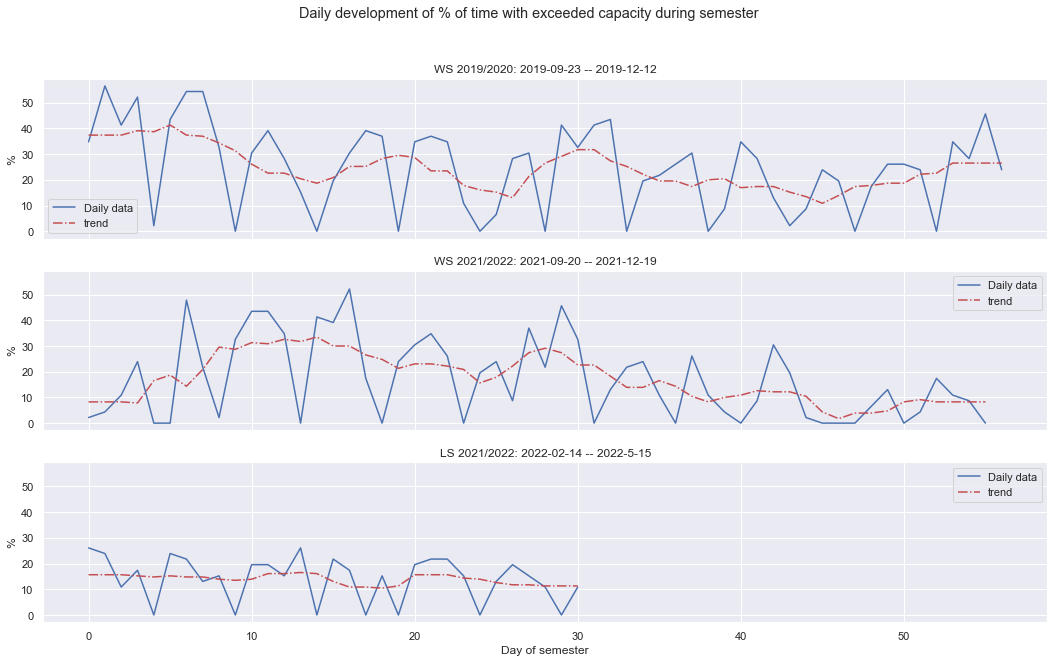

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 10), sharex=True, sharey=True)
subplt_p_over_dev(ax1, exceeded_df, ('2019-09-23', '2019-12-12'), 'WS 2019/2020')
subplt_p_over_dev(ax2, exceeded_df, ('2021-09-20', '2021-12-19'), 'WS 2021/2022')
subplt_p_over_dev(ax3, exceeded_df, ('2022-02-14', '2022-5-15'), 'LS 2021/2022')
plt.xlabel('Day of semester')
plt.suptitle('Daily development of % of time with exceeded capacity during semester')
plt.show()

In [131]:
tmp = exceeded_df.loc['2019-09-23':'2019-12-12']
print(f'WS 2019/2020: 2019-09-23 -- 2019-12-12')
print(f'Percentage of study days, when the number of simultaneous visitors exceedes the capacity: {round(len(tmp[tmp["if_exceeded"] == 1]) / len(tmp) * 100, 2)}%')
print(f"Avg % of temporal 5 min bins with exceeded capacity (only for days when the capacity is exceeded): {tmp[tmp['if_exceeded'] == 1]['p_over'].mean():2.2f}%\n")

tmp = exceeded_df.loc['2021-09-20':'2021-12-19']
print(f'WS 2021/2022: 2021-09-20 -- 2021-09-20')
print(f'Percentage of study days, when the number of simultaneous visitors exceedes the capacity: {round(len(tmp[tmp["if_exceeded"] == 1]) / len(tmp) * 100, 2)}%')
print(f"Avg % of temporal 5 min bins with exceeded capacity (only for days when the capacity is exceeded): {tmp[tmp['if_exceeded'] == 1]['p_over'].mean():2.2f}%\n")

tmp = exceeded_df.loc['2022-02-14':'2022-5-15']
print(f'LS 2021/2022: 2022-02-14 -- 2022-5-15')
print(f'Percentage of study days, when the number of simultaneous visitors exceedes the capacity: {round(len(tmp[tmp["if_exceeded"] == 1]) / len(tmp) * 100, 2)}%')
print(f"Avg % of temporal 5 min bins with exceeded capacity (only for days when the capacity is exceeded): {tmp[tmp['if_exceeded'] == 1]['p_over'].mean():2.2f}%")

WS 2019/2020: 2019-09-23 -- 2019-12-12
Percentage of study days, when the number of simultaneous visitors exceedes the capacity: 84.21%
Avg % of temporal 5 min bins with exceeded capacity (only for days when the capacity is exceeded): 29.48%

WS 2021/2022: 2021-09-20 -- 2021-09-20
Percentage of study days, when the number of simultaneous visitors exceedes the capacity: 76.79%
Avg % of temporal 5 min bins with exceeded capacity (only for days when the capacity is exceeded): 22.19%

LS 2021/2022: 2022-02-14 -- 2022-5-15
Percentage of study days, when the number of simultaneous visitors exceedes the capacity: 77.42%
Avg % of temporal 5 min bins with exceeded capacity (only for days when the capacity is exceeded): 18.12%


In [132]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

exceeded_df.groupby('dayofweek').mean().reindex(cats)

if_exceeded   p_over
dayofweek                      
Monday          0.9333  21.2323
Tuesday         0.9655  26.1617
Wednesday       0.9643  27.6396
Thursday        1.0000  21.6641
Friday          0.1071   0.2325

In [141]:
exceeded_df[exceeded_df['if_exceeded'] == 1].groupby('dayofweek').mean().reindex(cats)

if_exceeded   p_over
dayofweek                      
Monday             1.0  22.7489
Tuesday            1.0  27.0961
Wednesday          1.0  28.6633
Thursday           1.0  21.6641
Friday             1.0   2.1700

In [133]:
display(exceeded_df.loc['2019-09-23':'2019-12-12'].groupby('dayofweek').mean().reindex(cats))
display(exceeded_df.loc['2021-09-20':'2021-12-19'].groupby('dayofweek').mean().reindex(cats))
display(exceeded_df.loc['2022-02-14':'2022-5-15'].groupby('dayofweek').mean().reindex(cats))

if_exceeded   p_over
dayofweek                      
Monday          1.0000  26.6800
Tuesday         1.0000  32.6083
Wednesday       1.0000  35.7700
Thursday        1.0000  27.7167
Friday          0.1818   0.3945

if_exceeded   p_over
dayofweek                      
Monday          0.8333  17.3917
Tuesday         0.9091  22.1336
Wednesday       1.0000  27.6682
Thursday        1.0000  17.7864
Friday          0.0909   0.1973

if_exceeded   p_over
dayofweek                      
Monday          1.0000  19.2557
Tuesday         1.0000  20.6533
Wednesday       0.8333  12.6817
Thursday        1.0000  16.6683
Friday          0.0000   0.0000